In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
classification_report,
confusion_matrix,
roc_auc_score,
roc_curve,
accuracy_score
)


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

RANDOM_STATE = 42

In [2]:
#%% Load and clean
print("="*55)
print("STEP 1: Load and clean")
print("="*55)

STEP 1: Load and clean


In [3]:
CSV_PATH = "risk_factors_cervical_cancer.csv"

# Load the CSV
df = pd.read_csv(CSV_PATH)

# Replace the dataset's missing placeholders ('?') with real NaN
# and coerce all columns to numeric where possible
# (Strings like '?' will become NaN)
df = df.replace('?', np.nan)
df = df.apply(pd.to_numeric, errors='coerce')


print("\nRaw shape:", df.shape)
print("Preview after coercion (first 5 rows):")
print(df.head())


Raw shape: (858, 36)
Preview after coercion (first 5 rows):
   Age  Number of sexual partners  First sexual intercourse  \
0   18                        4.0                      15.0   
1   15                        1.0                      14.0   
2   34                        1.0                       NaN   
3   52                        5.0                      16.0   
4   46                        3.0                      21.0   

   Num of pregnancies  Smokes  Smokes (years)  Smokes (packs/year)  \
0                 1.0     0.0             0.0                  0.0   
1                 1.0     0.0             0.0                  0.0   
2                 1.0     0.0             0.0                  0.0   
3                 4.0     1.0            37.0                 37.0   
4                 4.0     0.0             0.0                  0.0   

   Hormonal Contraceptives  Hormonal Contraceptives (years)  IUD  ...  \
0                      0.0                              0.0  0.0  

In [4]:
#%% 2. TARGET & FEATURES
print("="*55)
print("STEP 1:2. TARGET & FEATURES")
print("="*55)

STEP 1:2. TARGET & FEATURES


In [6]:
# We use Biopsy as the gold-standard target. Drop rows where Biopsy is missing.
if 'Biopsy' not in df.columns:
    raise ValueError("Column 'Biopsy' not found. Please check your dataset.")

# Drop rows without target
df = df.dropna(subset=['Biopsy'])

# Avoid leakage by excluding other screening test columns that directly measure the outcome
LEAKAGE_COLS = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy']

feature_cols = [c for c in df.columns if c not in LEAKAGE_COLS]
X = df[feature_cols]
y = df['Biopsy'].astype(int) # ensure integer 0/1

print("\nAfter dropping rows with missing target:")
print("Shape X:", X.shape, "| Shape y:", y.shape)

# Quick class balance check
print("\nClass distribution (Biopsy):")
print(y.value_counts().sort_index())


After dropping rows with missing target:
Shape X: (858, 32) | Shape y: (858,)

Class distribution (Biopsy):
Biopsy
0    803
1     55
Name: count, dtype: int64


In [7]:
#%% 2. TRAIN/TEST SPLIT (STRATIFIED)
print("="*55)
print("STEP 3: TRAIN/TEST SPLIT (STRATIFIED)")
print("="*55)

STEP 3: TRAIN/TEST SPLIT (STRATIFIED)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain shape:", X_train.shape, "| Test shape:", X_test.shape)


Train shape: (686, 32) | Test shape: (172, 32)


In [9]:
#%% 4. HELPER PLOTTING FUNCTIONS (Matplotlib only)
print("="*55)
print("STEP 4: HELPER PLOTTING FUNCTIONS (Matplotlib only)")
print("="*55)

STEP 4: HELPER PLOTTING FUNCTIONS (Matplotlib only)


In [19]:
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    """Plot a simple confusion matrix with counts."""
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Pred 0', 'Pred 1'])
    plt.yticks(tick_marks, ['True 0', 'True 1'])

    # Annotate counts
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     verticalalignment="center")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


def plot_roc(y_true, y_scores, label="Model"):
    """Plot ROC curve and display AUC."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


In [20]:
#%% 5. PIPELINES (Impute always; Scale when useful)
print("="*55)
print("STEP 5: PIPELINES (Impute always; Scale when useful)")
print("="*55)

STEP 5: PIPELINES (Impute always; Scale when useful)


In [21]:
# Logistic Regression pipeline (impute + scale)
log_reg_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE))
])

# SVM pipeline (impute + scale); probability=True to enable ROC
svm_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, class_weight='balanced', kernel='rbf', random_state=RANDOM_STATE))
])

# Random Forest pipeline (impute only; trees don't need scaling)
rf_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE))
])


In [22]:
#%% 6. TRAIN & EVALUATE (single train/test split)
print("="*55)
print("STEP 6: TRAIN & EVALUATE (single train/test split)")
print("="*55)

STEP 6: TRAIN & EVALUATE (single train/test split)



=== Logistic Regression ===
Accuracy: 0.797
Classification Report:
               precision    recall  f1-score   support

           0      0.938     0.839     0.885       161
           1      0.071     0.182     0.103        11

    accuracy                          0.797       172
   macro avg      0.504     0.510     0.494       172
weighted avg      0.882     0.797     0.835       172



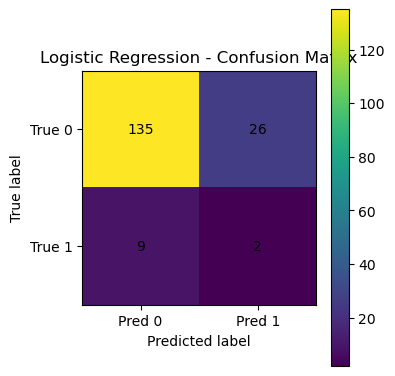

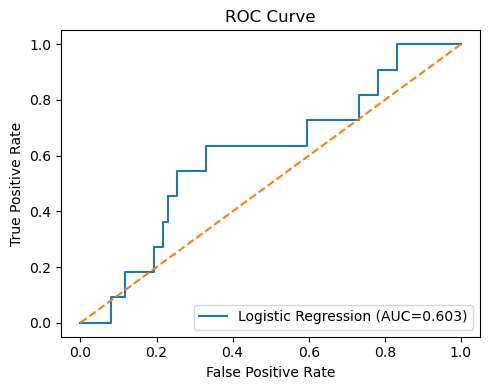


=== Random Forest ===
Accuracy: 0.936
Classification Report:
               precision    recall  f1-score   support

           0      0.941     0.994     0.967       161
           1      0.500     0.091     0.154        11

    accuracy                          0.936       172
   macro avg      0.721     0.542     0.560       172
weighted avg      0.913     0.936     0.915       172



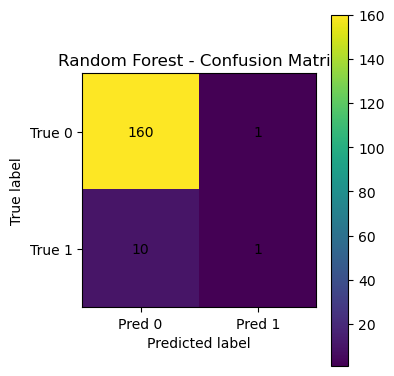

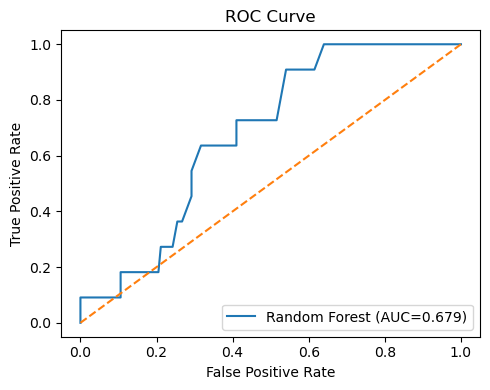


=== SVM (RBF) ===
Accuracy: 0.860
Classification Report:
               precision    recall  f1-score   support

           0      0.931     0.919     0.925       161
           1      0.000     0.000     0.000        11

    accuracy                          0.860       172
   macro avg      0.465     0.460     0.463       172
weighted avg      0.871     0.860     0.866       172



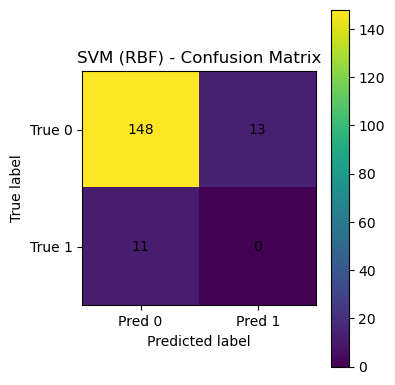

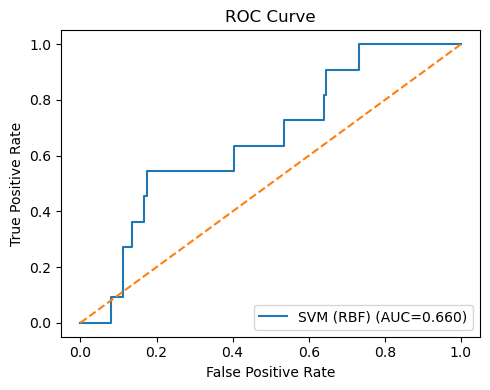

In [23]:
def fit_and_report(name, pipe, X_train, X_test, y_train, y_test):
    pipe.fit(X_train, y_train)

    # Predictions and basic metrics
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=3))

    
# Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, title=f"{name} - Confusion Matrix")

    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        y_scores = pipe.predict_proba(X_test)[:, 1]
    else:
        if hasattr(pipe.named_steps['clf'], 'decision_function'):
            y_scores = pipe.decision_function(X_test)
        else:
            print("ROC not available for this model.")
            return pipe

    plot_roc(y_test, y_scores, label=name)
    return pipe

# Train & evaluate each model
log_reg_trained = fit_and_report("Logistic Regression", log_reg_pipe, X_train, X_test, y_train, y_test)
rf_trained = fit_and_report("Random Forest", rf_pipe, X_train, X_test, y_train, y_test)
svm_trained = fit_and_report("SVM (RBF)", svm_pipe, X_train, X_test, y_train, y_test)


In [24]:
#%% 7. Cross-validated AUC (robustness check)
print("="*55)
print("STEP 7: Cross-validated AUC (robustness check)")
print("="*55)

STEP 7: Cross-validated AUC (robustness check)


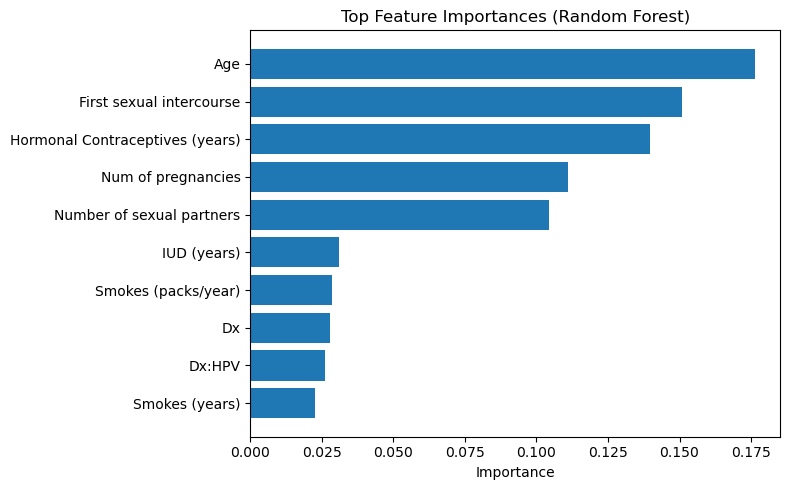

In [25]:
rf_clf = rf_trained.named_steps['clf']
importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]

TOP_N = 10
top_idx = indices[:TOP_N]

plt.figure(figsize=(8, 5))
plt.barh(range(TOP_N), importances[top_idx][::-1])
plt.yticks(range(TOP_N), [feature_cols[i] for i in top_idx][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
